## Data analysis code for gain=5000 data taken on 08/28/2025. Binning 1x1
Used for scanning frequency on solid target. 

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

In [127]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\27'

# Define PC thresholds for binning=1x1

Text(0, 0.5, 'Number of Pixels')

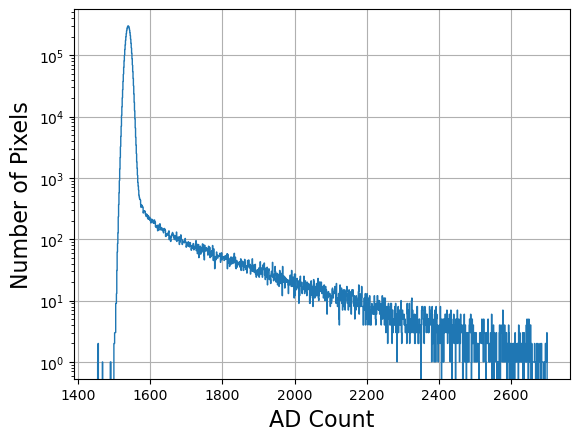

In [8]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0003'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[6.68641384e-02 7.00000000e+00 1.53900000e+03]
[69, 99, 1513, 1557, 1480, 1900]
fit region: AD count =  1520 to  1549
Fit Converged
Converged with chi-squared 285.01827567792697
Number of degrees of freedom, dof = 27
Reduced chi-squared 10.556232432515813
Inital guess values:
  p0 = [0.06686413838421455, 7, 1539]
Best fit values:
  pf = [0.06585104874902509, 6.920933505231206, 1539.1509828143382]
Uncertainties in the best fit values:
  pferr = [3.1944530137533086e-05, 0.003455203978946764, 0.004097022010173912]
5 sigma threshold is 1573.7556503404942 with uncertainty 0.02137304190490773


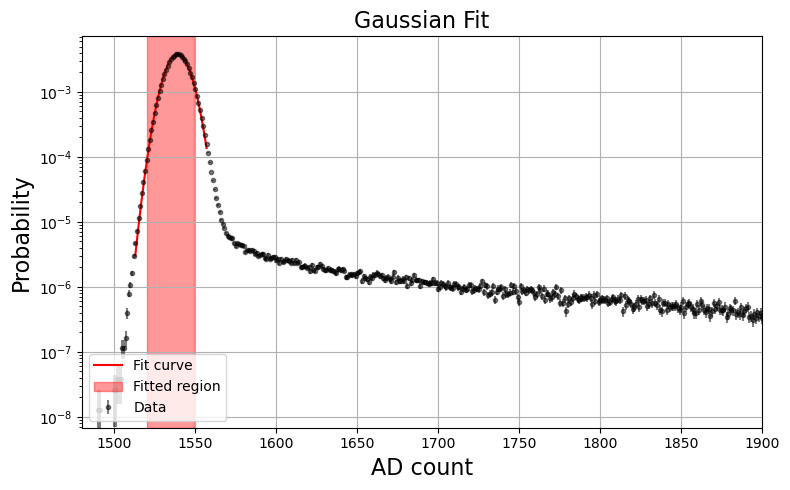

In [9]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1550

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1574

## Background counts with 20mW probe

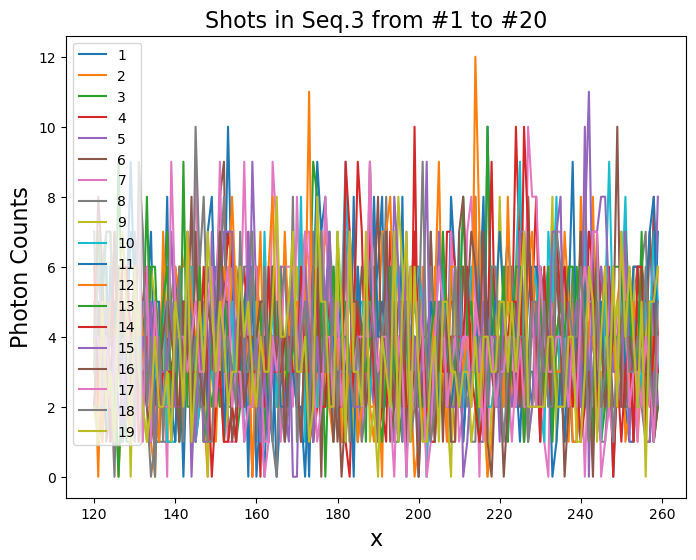

total # of photons =  9845
total_counts= 19
average # of photons =  518.1578947368421


In [74]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\27'
seq = 3 #sequence number
count_b_start=1
count_b_end=20

folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #average number of photons
fig = plt.figure(20, figsize=(8,6))
total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
        #if count_b==1 or count_b==2:
        #    print("skip count_b=", count_b)
        #    continue
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1574]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            # plt.plot(np.arange(512),cross_section_x, label=count_b)
            # sum_array.append(np.sum(cross_section_x))
            plt.plot(np.arange(120,260,1),cross_section_x[120:260], label=count_b)
            sum_array.append(np.sum(cross_section_x[120:260]))
            total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
print("total_counts=", total_counts)
print("average # of photons = ", np.sum(sum_array)/total_counts)


# BaF_Scanning: Sort by frequecies and plot

In [124]:
folder_path_day = r'C:\Experiments\lyman29\BaF_scanning\2025\08\27'

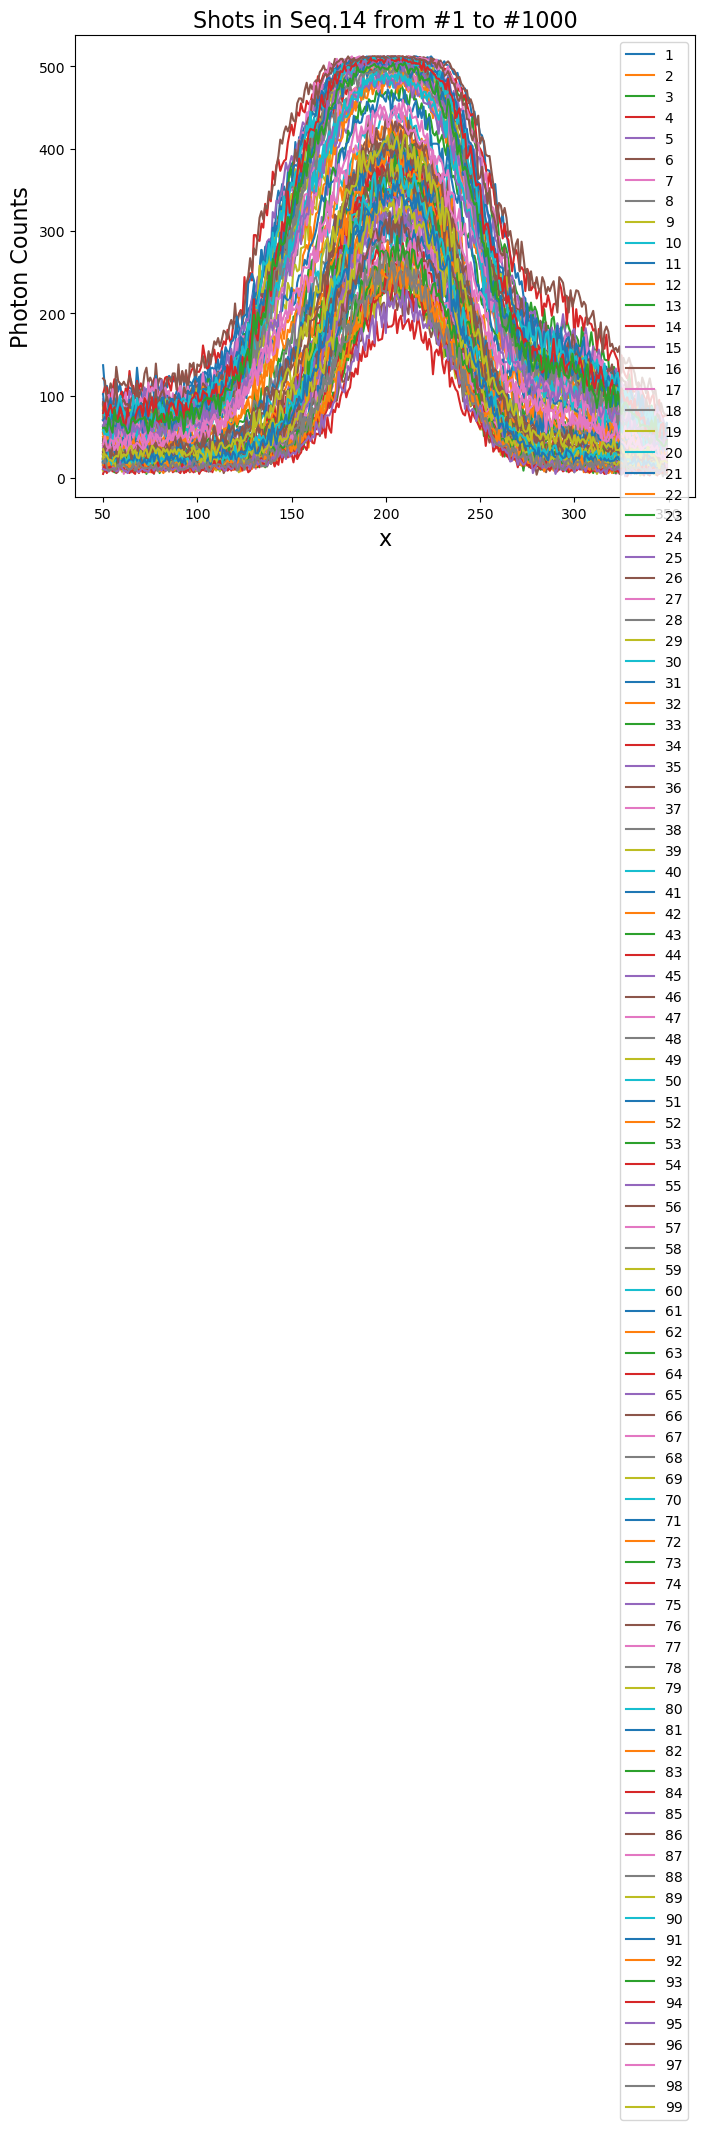

Sorted Frequencies: [348.661089 348.661094 348.661099 348.661104 348.661109 348.661114
 348.661119 348.661124 348.661129 348.661134 348.661139 348.661144
 348.661149 348.661154 348.661159 348.661164 348.661169 348.661174
 348.661179 348.661184]
Summed Photons: [20619.2  25934.2  24390.2  23077.6  36202.8  34001.8  41469.8  64422.25
 63745.6  72488.4  74282.   73178.2  68464.6  69267.6  54522.2  48106.6
 35856.2  28328.6  28123.6  22641.2 ]
stds: [7749.746686182717, 5009.010451176959, 6996.254869571291, 3069.9425564658372, 10510.27686124395, 4685.13198319962, 8982.388724609953, 12953.806014063975, 15901.663444432472, 6279.06046315848, 9516.4435321185, 6365.697031747583, 3367.1950938429454, 5966.890505112357, 7247.290990432219, 18021.15674145253, 6314.008172310201, 5300.822322998574, 5754.188022649242, 4554.725370425752]


In [125]:
seq=14

folder_path = folder_path_day + '\\%.4i'%seq
count_b_start=1
count_b_end=1000

photon_array=[] #average number of photons
freq_array=[]


fig = plt.figure(20, figsize=(8,6))

for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
        with h5py.File(file_path, 'r') as file:
            freq_read = file['devices/LaserLockGUI/remote_device_operation'][0][0]
            freq_array.append(round(freq_read, 6))
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1574]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            plt.plot(np.arange(50,350,1),cross_section_x[50:350], label=count_b)
            photon_array.append(np.sum(cross_section_x[50:350]))
            total_counts+=1


plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

# print(photon_array)
# print(freq_array)

## Next we sort the LIF and frequency data
combined = np.column_stack((freq_array, photon_array))
unique_freqs = np.unique(combined[:, 0]) # Get unique frequencies

# Get averaged photons for each unique frequency
mean_photons = []
std_array=[]
for freq in unique_freqs:
    mask = combined[:, 0] == freq # create boolean by comparing freq_array to freq
    photons_for_freq = combined[mask][:, 1]
    mean_photons.append(photons_for_freq.mean())
    std_array.append(photons_for_freq.std(ddof=1))

sorted_freq_array = unique_freqs
sorted_photon_array = np.array(mean_photons)

print("Sorted Frequencies:", sorted_freq_array)
print("Summed Photons:", sorted_photon_array)
print("stds:", std_array)

# Let's plot

(-130.0, 30.0)

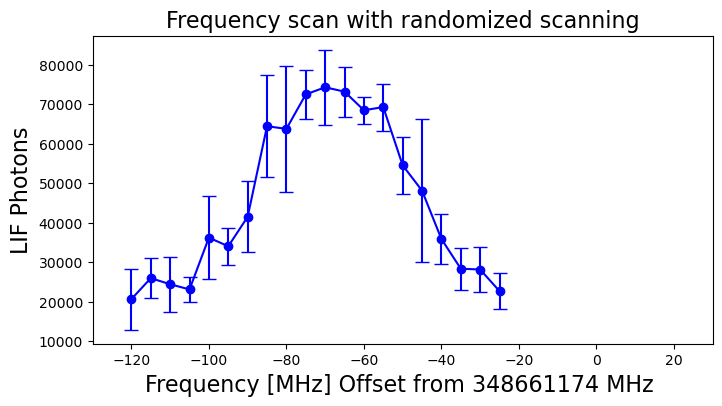

In [126]:
sorted_freq_array = sorted_freq_array*1E6 - 348661174 - 35 #Frequenct offset from Rb = 35MHz
plt.figure(figsize=(8,4))
plt.errorbar(sorted_freq_array, sorted_photon_array, yerr=std_array, fmt='bo-', capsize=5)
plt.title("Frequency scan with randomized scanning", fontsize=16)
plt.xlabel("Frequency [MHz] Offset from 348661174 MHz ", fontsize=16)
plt.ylabel("LIF Photons", fontsize=16)
# plt.grid()
plt.xlim([-130,30])

# sorted_freq_array_12=sorted_freq_array
# sorted_photon_array_12=sorted_photon_array
# std_array_12=std_array

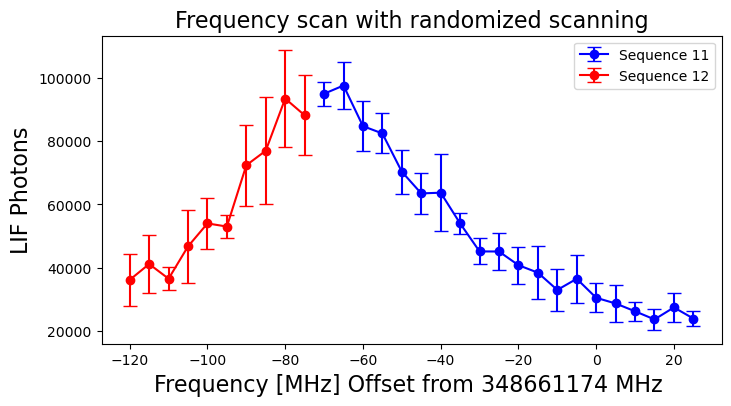

In [94]:
plt.figure(figsize=(8,4))
plt.errorbar(sorted_freq_array_11, sorted_photon_array_11, yerr=std_array_11, fmt='bo-', label="Sequence 11", capsize=5)
plt.errorbar(sorted_freq_array_12, sorted_photon_array_12, yerr=std_array_12, fmt='ro-', label="Sequence 12", capsize=5)
plt.title("Frequency scan with randomized scanning", fontsize=16)
plt.xlabel("Frequency [MHz] Offset from 348661174 MHz ", fontsize=16)
plt.ylabel("LIF Photons", fontsize=16)
plt.legend()

# B-field scan

In [129]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\28'

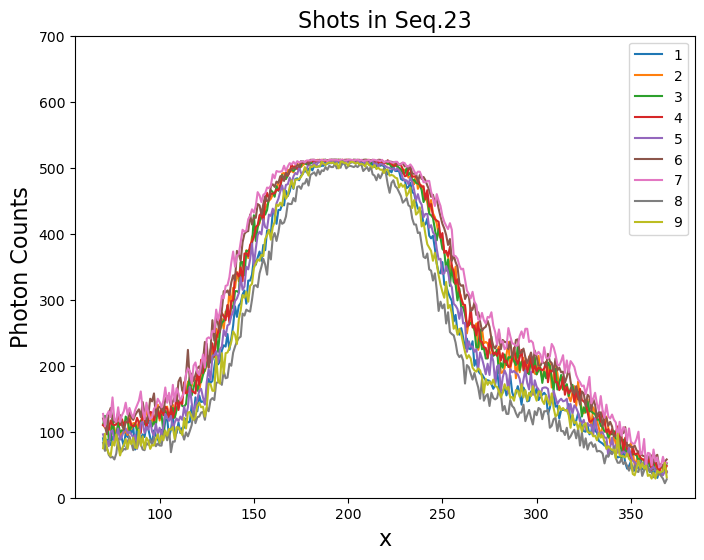

[75029, 83724, 83120, 84383, 78377, 88005, 90554, 68333, 73379]
[]


In [106]:
seq=23

folder_path = folder_path_day + '\\%.4i'%seq

photon_array=[] #average number of photons

fig = plt.figure(20, figsize=(8,6))
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if not count_b==0:
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1574]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            plt.plot(np.arange(70,370,1),cross_section_x[70:370], label=count_b)
            photon_array.append(np.sum(cross_section_x[70:370]))

plt.xlabel('x', fontsize=16)
plt.ylim([0,700])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i' %(seq), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print(photon_array)

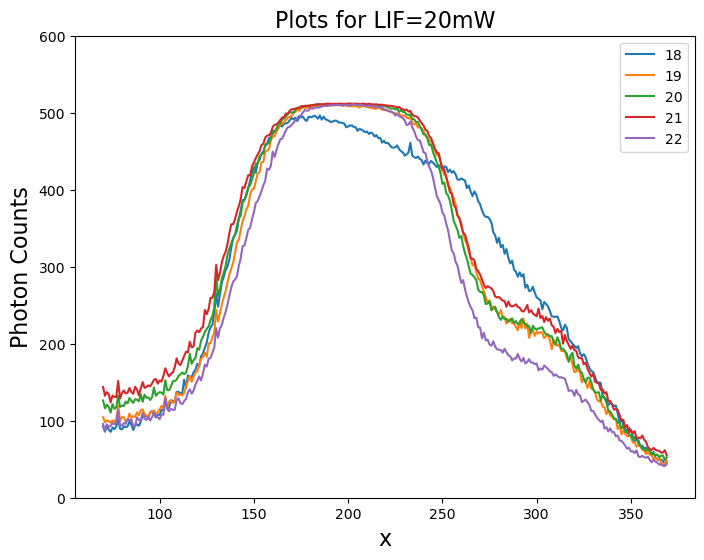

In [122]:
## get averaged plot shape in each sequence

fig = plt.figure(20, figsize=(8,6))

for seq in np.arange(18,23):
    folder_path = folder_path_day + '\\%.4i'%seq
    photon_array=[] #average number of photons
    freq_array=[]
    cross_section_x_tot=None
    count=0
    
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        if not count_b==0:
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<1574]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                if cross_section_x_tot is None:
                    cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                cross_section_x_tot += cross_section_x 
            count+=1
    
    
    cross_section_x_tot = cross_section_x_tot/count
    plt.plot(np.arange(70,370,1),cross_section_x_tot[70:370], label=seq)

plt.xlabel('x', fontsize=16)
plt.ylim([0,600])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Plots for LIF=20mW', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

# Let's reduce the EMCCD gain to 20

Text(0, 0.5, 'Number of Pixels')

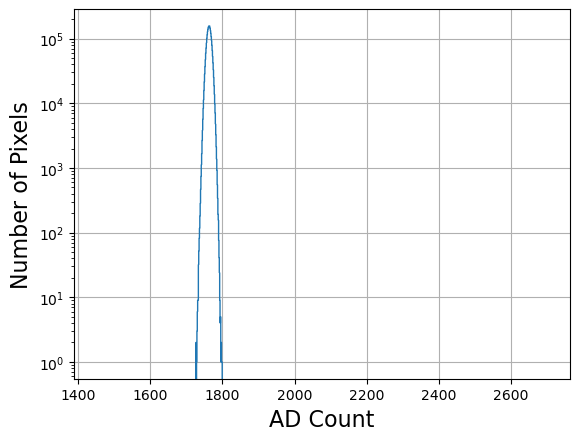

In [193]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0086'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[3.51440228e-02 7.00000000e+00 1.76300000e+03]
[299, 329, 1743, 1787, 1480, 1900]
fit region: AD count =  1750 to  1779
Fit Converged
Converged with chi-squared 82.58988091185788
Number of degrees of freedom, dof = 27
Reduced chi-squared 3.0588844782169584
Inital guess values:
  p0 = [0.035144022816307526, 7, 1763]
Best fit values:
  pf = [0.03327141092202697, 6.639789039069597, 1763.2603873854935]
Uncertainties in the best fit values:
  pferr = [2.107636403389104e-05, 0.004002403919458907, 0.00454101274902192]
5 sigma threshold is 1796.4593325808414 with uncertainty 0.024553032346316457


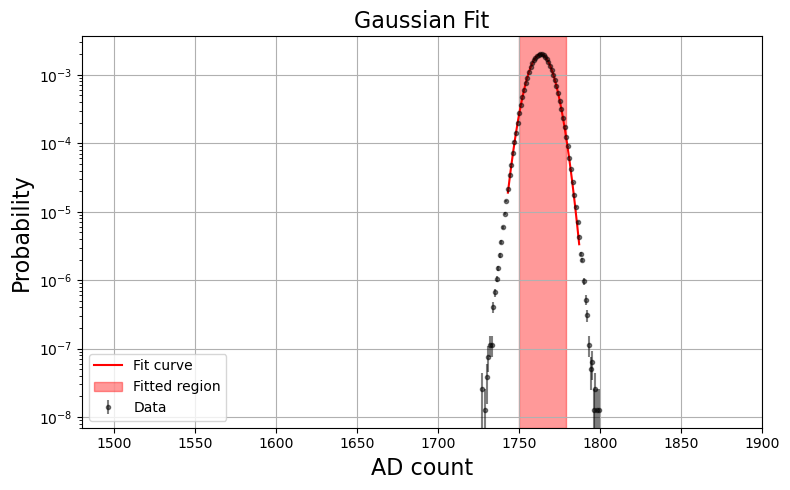

In [194]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1750
End_gaussian=1780

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1796

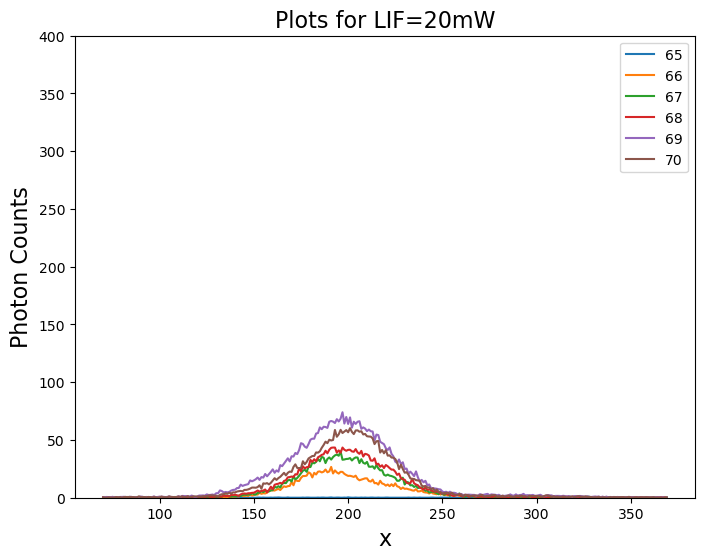

In [191]:
## get averaged plot shape in each sequence

fig = plt.figure(20, figsize=(8,6))

for seq in np.arange(65,71):
    if not seq==55:
        folder_path = folder_path_day + '\\%.4i'%seq
        photon_array=[] #average number of photons
        freq_array=[]
        cross_section_x_tot=None
        count=0
        
        for count_b, filename in enumerate(os.listdir(folder_path)): 
            file_path = os.path.join(folder_path, filename)
            if not count_b==0:
                with h5py.File(file_path, 'r') as file:
                    image_data = file['images/camera/fluorescence/frame'][:]
                    image_data[image_data<1740]=0
                    cross_section_x = np.count_nonzero(image_data, axis=0)
                    if cross_section_x_tot is None:
                        cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                    cross_section_x_tot += cross_section_x 
                count+=1
        
        
        cross_section_x_tot = cross_section_x_tot/count
        plt.plot(np.arange(70,370,1),cross_section_x_tot[70:370], label=seq)

plt.xlabel('x', fontsize=16)
plt.ylim([0,400])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Plots for LIF=20mW', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

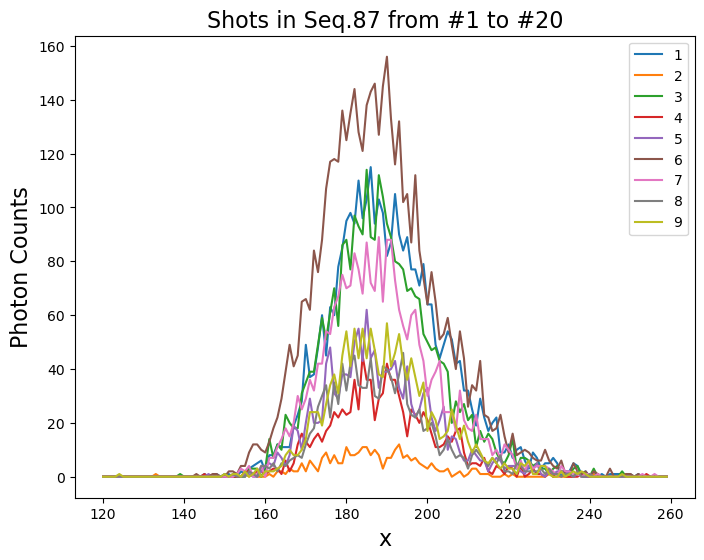

total # of photons =  19135
total_counts= 9
average # of photons =  2126.1111111111113


In [198]:
# Photon counts for each of the shots
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\28'
seq = 87 #sequence number
count_b_start=1
count_b_end=20


folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #average number of photons
fig = plt.figure(20, figsize=(8,6))
total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
        #if count_b==1 or count_b==2:
        #    print("skip count_b=", count_b)
        #    continue
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1796]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            # plt.plot(np.arange(512),cross_section_x, label=count_b)
            # sum_array.append(np.sum(cross_section_x))
            plt.plot(np.arange(120,260,1),cross_section_x[120:260], label=count_b)
            sum_array.append(np.sum(cross_section_x[120:260]))
            total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
print("total_counts=", total_counts)
print("average # of photons = ", np.sum(sum_array)/total_counts)
